In [ ]:
#將unet的資料灌入resNet152/Xception看結果

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D, Activation
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [ ]:
train = np.load('/content/drive/My Drive/Colab Notebooks/AIMango/x_train_unetpred_1.npz')


In [ ]:
x_train = train["x"]


In [ ]:
train = np.load('/content/drive/My Drive/Colab Notebooks/AIMango/train1_preprocess.npz')
y_train = train["y"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0.]


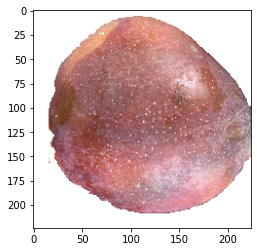

In [ ]:
plt.imshow(x_train[10])
# print()
print(y_train[10])

In [ ]:
test = np.load('/content/drive/My Drive/Colab Notebooks/AIMango/x_test_unetpred_1.npz')
x_test = test["x"]


In [ ]:
test = np.load('/content/drive/My Drive/Colab Notebooks/AIMango/test1_preprocess.npz')
y_test = test["y"]

In [ ]:
# import tensorflow
# y_train_cat = tensorflow.keras.utils.to_categorical(y_train, num_classes=3)
# y_test_cat = tensorflow.keras.utils.to_categorical(y_test, num_classes=3)
# x_train = x_train/255.0
# x_test = x_test/255.0

In [ ]:
y_test_cat = y_test
x_test_cat = x_test

In [ ]:
# # 隨機打亂
# permutation = np.random.permutation(len(y_test_cat))
# y_test_cat_shuffle = y_test_cat[permutation, :]
# x_test_shuffle = x_test[permutation, :]

In [ ]:
# x_valid = x_test_shuffle[:400]
# y_valid = y_test_cat_shuffle[:400]
# x_test = x_test_shuffle[400:]
# y_test = y_test_cat_shuffle[400:]
# print(x_valid.shape)
# print(y_valid.shape)
# print(x_test.shape)
# print(y_test.shape)

In [ ]:
x_valid = x_test_cat[:400]
y_valid = y_test_cat[:400]
x_test = x_test_cat[400:]
y_test = y_test_cat[400:]
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)


(400, 224, 224, 3)
(400, 3)
(400, 224, 224, 3)
(400, 3)


In [ ]:
y_test_ = y_test.argmax(axis=-1)
count = 0
for i in y_test_:
  if i == 0:
    count += 1
print(count)

138


In [ ]:
from tensorflow.keras.applications.xception import Xception
cnn = Xception(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = True
# BatchNormalization放在flatten後完全不對
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(3, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)

Using TensorFlow backend.


In [ ]:
print(x_train.shape)
print(y_train.shape)

(5600, 224, 224, 3)
(5600, 3)


In [ ]:
# weight_saver = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/AIMango/model_record/unet+xception/{epoch:02d}-{val_loss:.2f}.h5', monitor='val_dice_coef')
earlystop = EarlyStopping(patience=15, restore_best_weights=True)

In [ ]:
tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# learning rate decay
# def scheduler(epoch, lr):
#   if epoch <= 15:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(datagen.flow(x_train, y_train, batch_size=14),
                    steps_per_epoch=280,
                    epochs=80,  
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_valid, y_valid),
                    callbacks=[earlystop,ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)]
                    )


Epoch 1/80
280/280 [==============================] - 173s 616ms/step - loss: 1.7125 - accuracy: 0.5327 - val_loss: 0.7031 - val_accuracy: 0.6725 - lr: 0.0010
Epoch 2/80
280/280 [==============================] - 169s 603ms/step - loss: 0.7924 - accuracy: 0.6395 - val_loss: 0.5999 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 3/80
280/280 [==============================] - 168s 599ms/step - loss: 0.7330 - accuracy: 0.6781 - val_loss: 0.9875 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 4/80
280/280 [==============================] - 168s 599ms/step - loss: 0.7035 - accuracy: 0.7026 - val_loss: 0.5837 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 5/80
280/280 [==============================] - 168s 602ms/step - loss: 0.6417 - accuracy: 0.7349 - val_loss: 0.5593 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 6/80
280/280 [==============================] - 169s 602ms/step - loss: 0.6424 - accuracy: 0.7232 - val_loss: 0.5929 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 7/80
280/280 [==========================

In [ ]:
import os
# 儲存model
dir_path = "/content/drive/My Drive/Colab Notebooks/AIMango/model_record/unet+xception/0623"
if os.path.exists(dir_path):
  model.save("/content/drive/My Drive/Colab Notebooks/AIMango/Trained_model_mango/0616/xception+unet+trainable.h5")
else:
  os.mkdir(dir_path)
  model.save(dir_path + "/xception.h5")

# 儲存訓練完的accuracy, loss
import pickle
with open(dir_path + "/xception.pickle", "wb") as file:
  pickle.dump(history.history, file)



Text(0, 0.5, 'Accuracy')

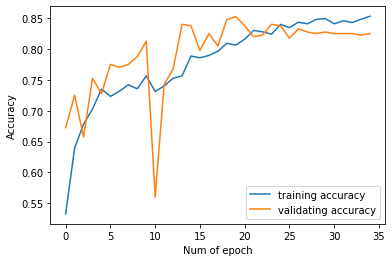

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(acc, label="training accuracy")
plt.plot(val_acc, label="validating accuracy")
plt.legend(loc="lower right")
plt.xlabel("Num of epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

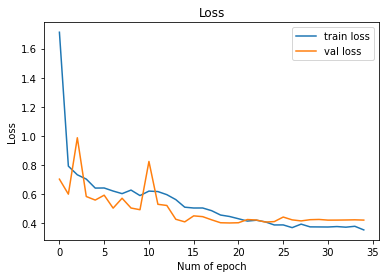

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss")
plt.legend(loc="upper right")
plt.xlabel("Num of epoch")
plt.ylabel("Loss")

In [ ]:
accuracy = model.evaluate(x_test, y_test)
accuracy

13/13 [==============================] - 4s 297ms/step - loss: 0.4671 - accuracy: 0.8275


[0.46705493330955505, 0.8274999856948853]

In [ ]:
# pre = model.predict_classes(x_test)
pre = model.predict(x_test)
# print(pre)
pre = pre.argmax(axis=-1)
# print(pre)
print(pre.shape)

(400,)


In [ ]:
ori_class = np.argmax(y_test, axis=-1)
print(ori_class.shape)

(400,)


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
ori_class = np.argmax(y_test, axis=-1)

mat = confusion_matrix(ori_class, pre)
trans = ['A','B','C']
c = ['{}(預測)'.format(i) for i in trans]
i = ['{}(真實)'.format(i) for i in trans]
df = pd.DataFrame(mat, columns=c, index=i)
df

#所以橫的是 y_pred,直的是y_true

,A(預測),B(預測),C(預測)
A(真實),118,18,2
B(真實),21,100,16
C(真實),2,10,113


In [ ]:
diff = np.nonzero(ori_class != pre)[0]
print(len(diff))
diff

69


array([  3,   5,  14,  15,  19,  32,  52,  56,  58,  59,  67,  68,  73,
        78,  84,  86,  90,  92, 100, 103, 109, 110, 121, 123, 135, 138,
       145, 155, 163, 166, 173, 178, 182, 183, 186, 187, 192, 194, 197,
       198, 204, 215, 216, 219, 220, 221, 225, 238, 243, 247, 252, 261,
       284, 287, 304, 307, 314, 321, 322, 339, 341, 347, 349, 361, 363,
       367, 375, 376, 391])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

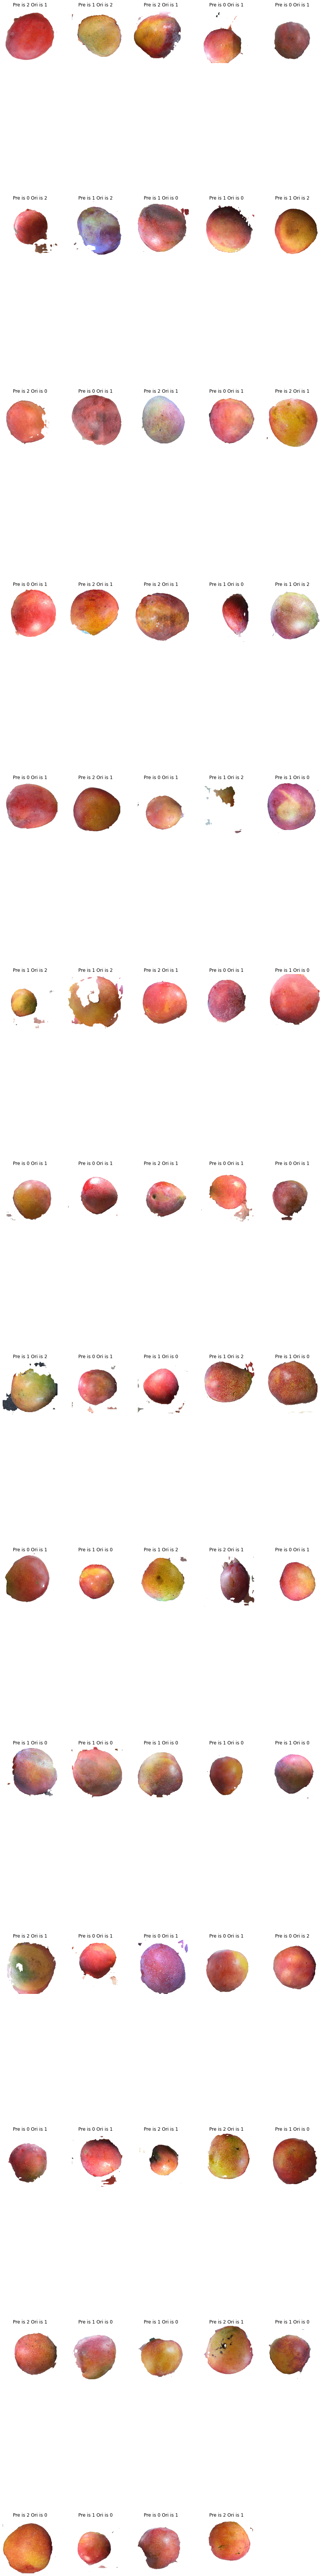

In [ ]:
falseimg = x_test[diff]
false_pre = pre[diff]
false_answer = ori_class[diff]
width = 5
height = int(len(diff) / 5) + 1
plt.figure(figsize=(15, 130))
for i in range(len(diff)):
  plt.subplot(height, width, i+1)
  t = "Pre is {} Ori is {}".format(false_pre[i], false_answer[i])
  plt.title(t)
  plt.axis("off")
  plt.imshow(falseimg[i])